# TV Recommendations

In [1]:
%load_ext lab_black
import altair as alt
import neo4j
import pandas as pd
import pyspark

alt.renderers.enable("mimetype") and None

In [2]:
spark = (
    pyspark.sql.SparkSession.builder.appName("TV Recommendations.ipynb")
    .master("local[4]")
    .getOrCreate()
)
spark

## Extract

In [3]:
kwargs_read_csv = dict(header=True, nullValue=r"\N", sep="\t", quote="")
kwargs_write_csv = dict(compression="gzip", escape='"', header=False, mode="overwrite")

### `name.basics.tsv.gz`

**name.basics.tsv.gz** – Contains the following information for names:
- nconst (string) - alphanumeric unique identifier of the name/person
- primaryName (string)– name by which the person is most often credited
- birthYear – in YYYY format
- deathYear – in YYYY format if applicable, else '\N'
- primaryProfession (array of strings)– the top-3 professions of the person
- knownForTitles (array of tconsts) – titles the person is known for

In [4]:
spark.sparkContext.addFile("https://datasets.imdbws.com/name.basics.tsv.gz")

In [5]:
spark.read.csv(
    pyspark.SparkFiles.get("name.basics.tsv.gz"),
    schema="""
        nconst string,
        primaryName string,
        birthYear integer,
        deathYear integer,
        primaryProfession string,
        knownForTitles string
    """,
    **kwargs_read_csv
).createOrReplaceTempView("`name.basics`")
spark.table("`name.basics`").limit(10).toPandas()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987.0,"soundtrack,actor,miscellaneous","tt0031983,tt0053137,tt0050419,tt0072308"
1,nm0000002,Lauren Bacall,1924,2014.0,"actress,soundtrack","tt0038355,tt0071877,tt0037382,tt0117057"
2,nm0000003,Brigitte Bardot,1934,NaN,"actress,soundtrack,music_department","tt0054452,tt0059956,tt0057345,tt0049189"
3,nm0000004,John Belushi,1949,1982.0,"actor,soundtrack,writer","tt0080455,tt0078723,tt0077975,tt0072562"
4,nm0000005,Ingmar Bergman,1918,2007.0,"writer,director,actor","tt0083922,tt0060827,tt0050986,tt0050976"
5,nm0000006,Ingrid Bergman,1915,1982.0,"actress,soundtrack,producer","tt0038787,tt0034583,tt0036855,tt0038109"
6,nm0000007,Humphrey Bogart,1899,1957.0,"actor,soundtrack,producer","tt0033870,tt0034583,tt0043265,tt0040897"
7,nm0000008,Marlon Brando,1924,2004.0,"actor,soundtrack,director","tt0047296,tt0078788,tt0070849,tt0068646"
8,nm0000009,Richard Burton,1925,1984.0,"actor,soundtrack,producer","tt0059749,tt0057877,tt0087803,tt0061184"
9,nm0000010,James Cagney,1899,1986.0,"actor,soundtrack,director","tt0035575,tt0042041,tt0029870,tt0031867"


### `title.basics.tsv.gz`

**title.basics.tsv.gz** - Contains the following information for titles:
- tconst (string) - alphanumeric unique identifier of the title
- titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
- primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
- originalTitle (string) - original title, in the original language
- isAdult (boolean) - 0: non-adult title; 1: adult title
- startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
- endYear (YYYY) – TV Series end year. ‘\N’ for all other title types
- runtimeMinutes – primary runtime of the title, in minutes
- genres (string array) – includes up to three genres associated with the title

In [6]:
spark.sparkContext.addFile("https://datasets.imdbws.com/title.basics.tsv.gz")

In [7]:
spark.read.csv(
    pyspark.SparkFiles.get("title.basics.tsv.gz"),
    schema="""
        tconst string,
        titleType string,
        primaryTitle string,
        originalTitle string,
        isAdult integer,
        startYear integer,
        endYear integer,
        runtimeMinutes integer,
        genres string
    """,
    **kwargs_read_csv
).createOrReplaceTempView("`title.basics`")
spark.table("`title.basics`").limit(10).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,NaN,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,NaN,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,NaN,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,NaN,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,NaN,1,"Comedy,Short"
5,tt0000006,short,Chinese Opium Den,Chinese Opium Den,0,1894,NaN,1,Short
6,tt0000007,short,Corbett and Courtney Before the Kinetograph,Corbett and Courtney Before the Kinetograph,0,1894,NaN,1,"Short,Sport"
7,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,0,1894,NaN,1,"Documentary,Short"
8,tt0000009,short,Miss Jerry,Miss Jerry,0,1894,NaN,45,"Romance,Short"
9,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,NaN,1,"Documentary,Short"


### `title.episode.tsv.gz`

**title.episode.tsv.gz** – Contains the tv episode information. Fields include:
- tconst (string) - alphanumeric identifier of episode
- parentTconst (string) - alphanumeric identifier of the parent TV Series
- seasonNumber (integer) – season number the episode belongs to
- episodeNumber (integer) – episode number of the tconst in the TV series

In [8]:
spark.sparkContext.addFile("https://datasets.imdbws.com/title.episode.tsv.gz")

In [9]:
spark.read.csv(
    pyspark.SparkFiles.get("title.episode.tsv.gz"),
    schema="""
        tconst string,
        parentTconst string,
        seasonNumber int,
        episodeNumber int
    """,
    **kwargs_read_csv
).createOrReplaceTempView("`title.episode`")
spark.table("`title.episode`").limit(10).toPandas()

,tconst,parentTconst,seasonNumber,episodeNumber
0,tt0041951,tt0041038,1.0,9.0
1,tt0042816,tt0989125,1.0,17.0
2,tt0042889,tt0989125,NaN,NaN
3,tt0043426,tt0040051,3.0,42.0
4,tt0043631,tt0989125,2.0,16.0
5,tt0043693,tt0989125,2.0,8.0
6,tt0043710,tt0989125,3.0,3.0
7,tt0044093,tt0959862,1.0,6.0
8,tt0044668,tt0044243,2.0,16.0
9,tt0044901,tt0989125,3.0,46.0


### `title.principals.tsv.gz`

**title.principals.tsv.gz** – Contains the principal cast/crew for titles
- tconst (string) - alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given titleId
- nconst (string) - alphanumeric unique identifier of the name/person
- category (string) - the category of job that person was in
- job (string) - the specific job title if applicable, else '\N'
- characters (string) - the name of the character played if applicable, else '\N'

In [10]:
spark.sparkContext.addFile("https://datasets.imdbws.com/title.principals.tsv.gz")

In [11]:
spark.read.csv(
    pyspark.SparkFiles.get("title.principals.tsv.gz"),
    schema="""
        tconst string,
        ordering integer,
        nconst string,
        category string,
        job string,
        characters string
    """,
    **kwargs_read_csv
).createOrReplaceTempView("`title.principals`")
spark.table("`title.principals`").limit(10).toPandas()

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,None,"[""Self""]"
1,tt0000001,2,nm0005690,director,None,None
2,tt0000001,3,nm0374658,cinematographer,director of photography,None
3,tt0000002,1,nm0721526,director,None,None
4,tt0000002,2,nm1335271,composer,None,None
5,tt0000003,1,nm0721526,director,None,None
6,tt0000003,2,nm1770680,producer,producer,None
7,tt0000003,3,nm1335271,composer,None,None
8,tt0000003,4,nm5442200,editor,None,None
9,tt0000004,1,nm0721526,director,None,None


### `title.ratings.tsv.gz`

**title.ratings.tsv.gz** – Contains the IMDb rating and votes information for titles
- tconst (string) - alphanumeric unique identifier of the title
- averageRating – weighted average of all the individual user ratings
- numVotes - number of votes the title has received

In [12]:
spark.sparkContext.addFile("https://datasets.imdbws.com/title.ratings.tsv.gz")

In [13]:
spark.read.csv(
    pyspark.SparkFiles.get("title.ratings.tsv.gz"),
    schema="""
        tconst string,
        averageRating float,
        numVotes int
    """,
    **kwargs_read_csv
).createOrReplaceTempView("`title.ratings`")
spark.table("`title.ratings`").limit(10).toPandas()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1670
1,tt0000002,6.1,208
2,tt0000003,6.5,1394
3,tt0000004,6.2,123
4,tt0000005,6.2,2184
5,tt0000006,5.3,120
6,tt0000007,5.4,669
7,tt0000008,5.4,1839
8,tt0000009,6.0,155
9,tt0000010,6.9,6154


## Transform

### `person`

In [14]:
display(spark.table("`name.basics`").limit(10).toPandas())

spark.sql(
    """
    select nconst,
           primaryName,
           birthYear,
           deathYear,
           replace(primaryProfession, ",", ";") as primaryProfession,
           replace(knownForTitles, ",", ";")    as knownForTitles,
           replace(primaryProfession, ",", ";") as labels
    from `name.basics`;
    """
).createOrReplaceTempView("person")
display(spark.table("person").limit(10).toPandas())

spark.table("person").repartition(5).write.csv("data/person.csv.gz", **kwargs_write_csv)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987.0,"soundtrack,actor,miscellaneous","tt0031983,tt0053137,tt0050419,tt0072308"
1,nm0000002,Lauren Bacall,1924,2014.0,"actress,soundtrack","tt0038355,tt0071877,tt0037382,tt0117057"
2,nm0000003,Brigitte Bardot,1934,NaN,"actress,soundtrack,music_department","tt0054452,tt0059956,tt0057345,tt0049189"
3,nm0000004,John Belushi,1949,1982.0,"actor,soundtrack,writer","tt0080455,tt0078723,tt0077975,tt0072562"
4,nm0000005,Ingmar Bergman,1918,2007.0,"writer,director,actor","tt0083922,tt0060827,tt0050986,tt0050976"
5,nm0000006,Ingrid Bergman,1915,1982.0,"actress,soundtrack,producer","tt0038787,tt0034583,tt0036855,tt0038109"
6,nm0000007,Humphrey Bogart,1899,1957.0,"actor,soundtrack,producer","tt0033870,tt0034583,tt0043265,tt0040897"
7,nm0000008,Marlon Brando,1924,2004.0,"actor,soundtrack,director","tt0047296,tt0078788,tt0070849,tt0068646"
8,nm0000009,Richard Burton,1925,1984.0,"actor,soundtrack,producer","tt0059749,tt0057877,tt0087803,tt0061184"
9,nm0000010,James Cagney,1899,1986.0,"actor,soundtrack,director","tt0035575,tt0042041,tt0029870,tt0031867"


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,labels
0,nm0000001,Fred Astaire,1899,1987.0,soundtrack;actor;miscellaneous,tt0031983;tt0053137;tt0050419;tt0072308,soundtrack;actor;miscellaneous
1,nm0000002,Lauren Bacall,1924,2014.0,actress;soundtrack,tt0038355;tt0071877;tt0037382;tt0117057,actress;soundtrack
2,nm0000003,Brigitte Bardot,1934,NaN,actress;soundtrack;music_department,tt0054452;tt0059956;tt0057345;tt0049189,actress;soundtrack;music_department
3,nm0000004,John Belushi,1949,1982.0,actor;soundtrack;writer,tt0080455;tt0078723;tt0077975;tt0072562,actor;soundtrack;writer
4,nm0000005,Ingmar Bergman,1918,2007.0,writer;director;actor,tt0083922;tt0060827;tt0050986;tt0050976,writer;director;actor
5,nm0000006,Ingrid Bergman,1915,1982.0,actress;soundtrack;producer,tt0038787;tt0034583;tt0036855;tt0038109,actress;soundtrack;producer
6,nm0000007,Humphrey Bogart,1899,1957.0,actor;soundtrack;producer,tt0033870;tt0034583;tt0043265;tt0040897,actor;soundtrack;producer
7,nm0000008,Marlon Brando,1924,2004.0,actor;soundtrack;director,tt0047296;tt0078788;tt0070849;tt0068646,actor;soundtrack;director
8,nm0000009,Richard Burton,1925,1984.0,actor;soundtrack;producer,tt0059749;tt0057877;tt0087803;tt0061184,actor;soundtrack;producer
9,nm0000010,James Cagney,1899,1986.0,actor;soundtrack;director,tt0035575;tt0042041;tt0029870;tt0031867,actor;soundtrack;director


In [15]:
!echo 'nconst:ID(Person),primaryName,birthYear:long,deathYear:long,primaryProfession:string[],knownForTitles:string[],labels:LABEL' >data/person.header.csv

### `person.creditedFor`

In [16]:
display(spark.table("`title.principals`").limit(10).toPandas())

spark.sql(
    """
    select tconst,
           ordering,
           nconst,
           category,
           job,
           array_join(from_json(characters, "array<string>"), ";") as characters
    from `title.principals`;
    """
).createOrReplaceTempView("`person.creditedFor`")
display(spark.table("`person.creditedFor`").limit(10).toPandas())

spark.table("`person.creditedFor`").repartition(5).write.csv(
    "data/person.creditedFor.csv.gz", **kwargs_write_csv
)

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,None,"[""Self""]"
1,tt0000001,2,nm0005690,director,None,None
2,tt0000001,3,nm0374658,cinematographer,director of photography,None
3,tt0000002,1,nm0721526,director,None,None
4,tt0000002,2,nm1335271,composer,None,None
5,tt0000003,1,nm0721526,director,None,None
6,tt0000003,2,nm1770680,producer,producer,None
7,tt0000003,3,nm1335271,composer,None,None
8,tt0000003,4,nm5442200,editor,None,None
9,tt0000004,1,nm0721526,director,None,None


,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,None,Self
1,tt0000001,2,nm0005690,director,None,None
2,tt0000001,3,nm0374658,cinematographer,director of photography,None
3,tt0000002,1,nm0721526,director,None,None
4,tt0000002,2,nm1335271,composer,None,None
5,tt0000003,1,nm0721526,director,None,None
6,tt0000003,2,nm1770680,producer,producer,None
7,tt0000003,3,nm1335271,composer,None,None
8,tt0000003,4,nm5442200,editor,None,None
9,tt0000004,1,nm0721526,director,None,None


In [17]:
!echo 'tconst:END_ID(Title),ordering:long,nconst:START_ID(Person),category,job,characters:string[]' >data/person.creditedFor.header.csv

### `person.knownFor`

In [18]:
spark.sql(
    """
    select nconst,
           explode(split(knownForTitles, ",")) as tconst
    from `name.basics`
    where knownForTitles is not null;
    """
).createOrReplaceTempView("`person.knownFor`")
display(spark.table("`person.knownFor`").limit(10).toPandas())

spark.table("`person.knownFor`").repartition(5).write.csv(
    "data/person.knownFor.csv.gz", **kwargs_write_csv
)

,nconst,tconst
0,nm0000001,tt0031983
1,nm0000001,tt0053137
2,nm0000001,tt0050419
3,nm0000001,tt0072308
4,nm0000002,tt0038355
5,nm0000002,tt0071877
6,nm0000002,tt0037382
7,nm0000002,tt0117057
8,nm0000003,tt0054452
9,nm0000003,tt0059956


In [19]:
!echo 'nconst:START_ID(Person),tconst:END_ID(Title)' >data/person.knownFor.header.csv

### `title`

In [20]:
display(spark.table("`title.basics`").limit(10).toPandas())
display(spark.table("`title.ratings`").limit(10).toPandas())

spark.sql(
    """
    select tconst,
           titleType,
           primaryTitle,
           originalTitle,
           boolean(isAdult)                                             as isAdult,
           startYear,
           endYear,
           runtimeMinutes,
           replace(genres, ",", ";")                                    as genres,
           averageRating,
           numVotes,
           array_join(array(replace(genres, ",", ";"), titleType), ";") as labels
    from `title.basics` natural left join `title.ratings`;
    """
).createOrReplaceTempView("title")
display(spark.table("title").limit(10).toPandas())

spark.table("title").repartition(5).write.csv("data/title.csv.gz", **kwargs_write_csv)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,NaN,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,NaN,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,NaN,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,NaN,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,NaN,1,"Comedy,Short"
5,tt0000006,short,Chinese Opium Den,Chinese Opium Den,0,1894,NaN,1,Short
6,tt0000007,short,Corbett and Courtney Before the Kinetograph,Corbett and Courtney Before the Kinetograph,0,1894,NaN,1,"Short,Sport"
7,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,0,1894,NaN,1,"Documentary,Short"
8,tt0000009,short,Miss Jerry,Miss Jerry,0,1894,NaN,45,"Romance,Short"
9,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,NaN,1,"Documentary,Short"


,tconst,averageRating,numVotes
0,tt0000001,5.7,1670
1,tt0000002,6.1,208
2,tt0000003,6.5,1394
3,tt0000004,6.2,123
4,tt0000005,6.2,2184
5,tt0000006,5.3,120
6,tt0000007,5.4,669
7,tt0000008,5.4,1839
8,tt0000009,6.0,155
9,tt0000010,6.9,6154


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,labels
0,tt0000001,short,Carmencita,Carmencita,False,1894,NaN,1,Documentary;Short,5.7,1670,Documentary;Short;short
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,False,1892,NaN,5,Animation;Short,6.1,208,Animation;Short;short
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,False,1892,NaN,4,Animation;Comedy;Romance,6.5,1394,Animation;Comedy;Romance;short
3,tt0000004,short,Un bon bock,Un bon bock,False,1892,NaN,12,Animation;Short,6.2,123,Animation;Short;short
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,False,1893,NaN,1,Comedy;Short,6.2,2184,Comedy;Short;short
5,tt0000006,short,Chinese Opium Den,Chinese Opium Den,False,1894,NaN,1,Short,5.3,120,Short;short
6,tt0000007,short,Corbett and Courtney Before the Kinetograph,Corbett and Courtney Before the Kinetograph,False,1894,NaN,1,Short;Sport,5.4,669,Short;Sport;short
7,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,False,1894,NaN,1,Documentary;Short,5.4,1839,Documentary;Short;short
8,tt0000009,short,Miss Jerry,Miss Jerry,False,1894,NaN,45,Romance;Short,6.0,155,Romance;Short;short
9,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,False,1895,NaN,1,Documentary;Short,6.9,6154,Documentary;Short;short


In [21]:
!echo 'tconst:ID(Title),titleType,primaryTitle,originalTitle,isAdult:boolean,startYear:long,endYear:long,runtimeMinutes:long,genres:string[],averageRating:double,numVotes:long,labels:LABEL' >data/title.header.csv

### `title.partOfSeries`

In [22]:
display(spark.table("`title.episode`").limit(10).toPandas())

spark.table("`title.episode`").repartition(5).write.csv(
    "data/title.partOfSeries.csv.gz", **kwargs_write_csv
)

,tconst,parentTconst,seasonNumber,episodeNumber
0,tt0041951,tt0041038,1.0,9.0
1,tt0042816,tt0989125,1.0,17.0
2,tt0042889,tt0989125,NaN,NaN
3,tt0043426,tt0040051,3.0,42.0
4,tt0043631,tt0989125,2.0,16.0
5,tt0043693,tt0989125,2.0,8.0
6,tt0043710,tt0989125,3.0,3.0
7,tt0044093,tt0959862,1.0,6.0
8,tt0044668,tt0044243,2.0,16.0
9,tt0044901,tt0989125,3.0,46.0


In [23]:
!echo 'tconst:START_ID(Title),parentTconst:END_ID(Title),seasonNumber:long,episodeNumber:long' >data/title.partOfSeries.header.csv

## Load

In [24]:
!du -hd0 data

1.3G	data


```sh
# RUN THE FOLLOWING ON DOCKER HOST (OUTSIDE OF NOTEBOOK)

docker-compose stop neo4j

sudo rm -fr /tmp/neo4j/data

docker run --rm -it \
    -v "$(pwd)/data":/var/lib/neo4j/import \
    -v /tmp/neo4j/data:/data \
    neo4j:4.2.1 neo4j-admin import \
    --skip-duplicate-nodes \
    --skip-bad-relationships \
    --nodes='Person=import/person.header.csv,import/person.csv.gz/.+.csv.gz' \
    --nodes='Title=import/title.header.csv,import/title.csv.gz/.+.csv.gz' \
    --relationships='creditedFor=import/person.creditedFor.header.csv,import/person.creditedFor.csv.gz/.+.csv.gz' \
    --relationships='knownFor=import/person.knownFor.header.csv,import/person.knownFor.csv.gz/.+.csv.gz' \
    --relationships='partOfSeries=import/title.partOfSeries.header.csv,import/title.partOfSeries.csv.gz/.+.csv.gz'

docker-compose start neo4j
```

```sh
du -hd0 /tmp/neo4j/data
# 14G
```

```
IMPORT DONE in 6m 3s 504ms. 
Imported:
  18104055 nodes
  64448144 relationships
  251733551 properties
Peak memory usage: 904.4MiB
```

## Analize

```cypher
MATCH (title:Horror:tvSeries)
  WHERE title.averageRating > 8.5
    AND title.startYear > 2010
    AND title.numVotes > 500
RETURN title
  LIMIT 3;
```

### Anthony Hopkins' acting career

,primaryTitle,titleType,tconst,originalTitle,genres,startYear,isAdult,averageRating,numVotes,runtimeMinutes,endYear
0,Changes,short,tt11423798,Changes,"[Drama, Short]",1965.0,False,NaN,NaN,NaN,NaN
1,A Minor Operation,tvEpisode,tt0641172,A Minor Operation,"[Crime, Drama, Thriller]",1965.0,False,7.6,5.0,NaN,NaN
2,The Lion in Winter,movie,tt0063227,The Lion in Winter,"[Biography, Drama, History]",1968.0,False,7.9,28885.0,134.0,NaN
3,This Isn't Just One of Those Physical Things,tvEpisode,tt0985226,This Isn't Just One of Those Physical Things,[Drama],1968.0,False,NaN,NaN,NaN,NaN
4,Hamlet,movie,tt0064400,Hamlet,[Drama],1969.0,False,6.9,718.0,117.0,NaN


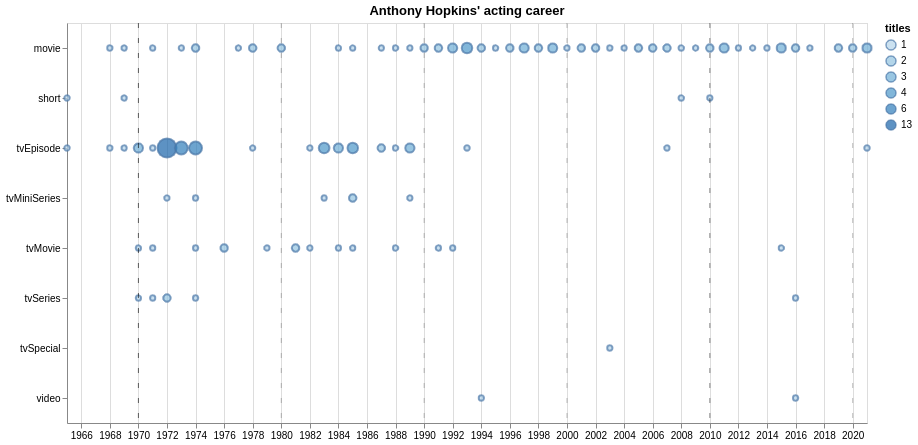

In [25]:
with neo4j.GraphDatabase.driver(
    "neo4j://localhost:7687"
) as driver, driver.session() as session:
    titles = pd.DataFrame(
        session.read_transaction(
            lambda tx, person: [
                {**record["title"]}
                for record in tx.run(
                    """
                    MATCH (person:actor {primaryName: $primaryName})
                    WITH person
                    LIMIT 1
                    MATCH (person)-[:creditedFor {category: 'actor'}]->(title)
                    RETURN title
                    ORDER BY title.startYear, title.titleType, title.primaryTitle;
                    """,
                    primaryName=person,
                )
            ],
            person="Anthony Hopkins",
        )
    )

display(titles.head())

chart = alt.Chart(
    (
        titles.assign(
            startYear=(
                titles["startYear"]
                .fillna(pd.to_datetime("now").year)
                .map(lambda x: f"{x:.0f}-01-01")
                .astype("datetime64[ns]")
            )
        )
        .groupby(["startYear", "titleType"])
        .size()
        .to_frame("titles")
        .reset_index()
    ),
    height=400,
    width=800,
    title="Anthony Hopkins' acting career",
)
display(
    chart.mark_point().encode(
        alt.X("startYear:T", scale=alt.Scale(zero=False), title=None),
        alt.Y("titleType:O", title=None),
        alt.Fill("titles:N", scale=alt.Scale(scheme="blues")),
        alt.Size("titles:Q", legend=None),
        alt.Tooltip(["year(startYear)", "titleType:O", "titles:Q"]),
    )
    + chart.transform_filter("year(datum.startYear) % 10 == 0")
    .mark_rule(opacity=0.25, strokeDash=[5, 10])
    .encode(x="startYear")
)

### "The Expanse" `averageRating` and `numVotes` progression

,primaryTitle,titleType,runtimeMinutes,tconst,originalTitle,genres,averageRating,startYear,numVotes,isAdult,episodeNumber,seasonNumber
0,Dulcinea,tvEpisode,45.0,tt3982200,Dulcinea,"[Drama, Mystery, Sci-Fi]",7.7,2015.0,3900.0,False,1,1
1,The Big Empty,tvEpisode,43.0,tt3982202,The Big Empty,"[Drama, Mystery, Sci-Fi]",7.7,2015.0,3264.0,False,2,1
2,Remember the Cant,tvEpisode,43.0,tt3983220,Remember the Cant,"[Drama, Mystery, Sci-Fi]",8.0,2015.0,3068.0,False,3,1
3,CQB,tvEpisode,42.0,tt3983230,CQB,"[Drama, Mystery, Sci-Fi]",8.7,2015.0,3320.0,False,4,1
4,Back to the Butcher,tvEpisode,43.0,tt3983242,Back to the Butcher,"[Drama, Mystery, Sci-Fi]",7.8,2016.0,2737.0,False,5,1


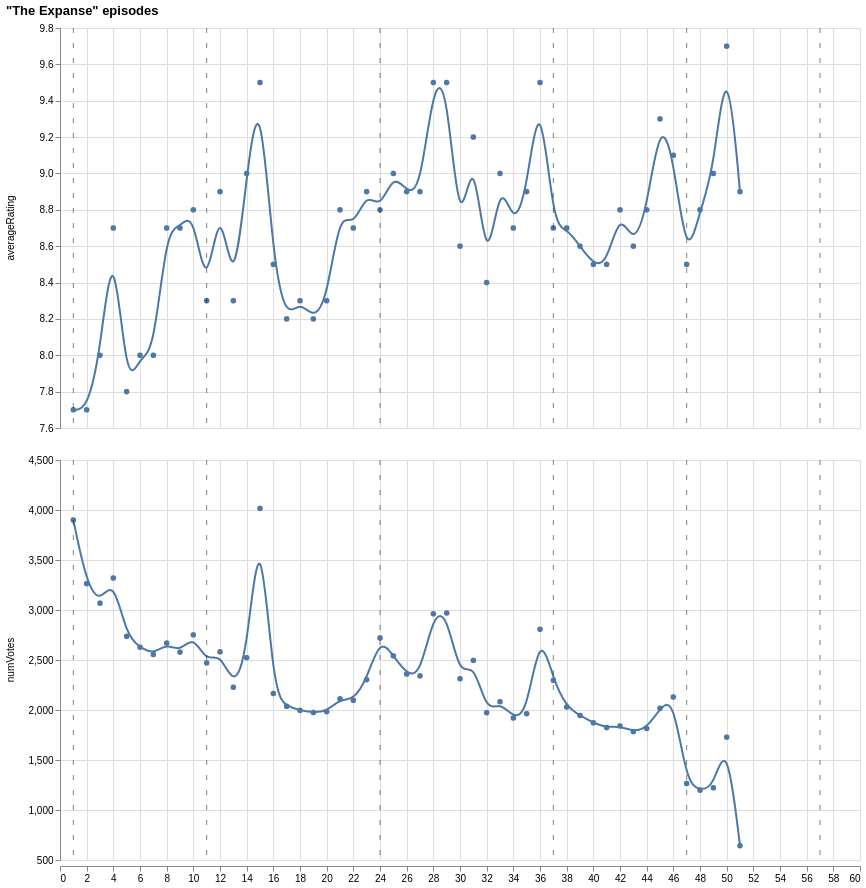

In [26]:
with neo4j.GraphDatabase.driver(
    "neo4j://localhost:7687"
) as driver, driver.session() as session:
    episodes = pd.DataFrame(
        session.read_transaction(
            lambda tx, title: [
                {**record["episode"], **record["partOfSeries"]}
                for record in tx.run(
                    """
                    MATCH (series:tvSeries {primaryTitle: $primaryTitle})
                    WITH series
                    LIMIT 1
                    MATCH (series)<-[partOfSeries:partOfSeries]-(episode)
                    RETURN episode, partOfSeries {.seasonNumber, .episodeNumber} as partOfSeries
                    ORDER BY partOfSeries.seasonNumber, partOfSeries.episodeNumber;
                    """,
                    primaryTitle=title,
                )
            ],
            title="The Expanse",
        )
    )

display(episodes.head())

chart = alt.Chart(
    episodes.reset_index()
    .eval("index = index + 1")
    .melt(
        ["index", "seasonNumber", "episodeNumber", "tconst", "primaryTitle"],
        ["averageRating", "numVotes"],
    ),
    height=400,
    width=800,
).transform_calculate(
    href="'https://www.imdb.com/title/' + datum.tconst + '/'",
    title="datum.seasonNumber + '.' + datum.episodeNumber + '. ' + datum.primaryTitle",
)
display(
    (
        chart.mark_line(interpolate="basis", point=True).encode(
            alt.X("index", title=None),
            alt.Y("value", scale=alt.Scale(zero=False), title=None),
            alt.Href("href:N"),
            alt.Tooltip(["title:N", "variable", "value"]),
        )
        + chart.transform_filter("datum.episodeNumber <=1 ")
        .mark_rule(opacity=0.5, strokeDash=[5, 10])
        .encode(x="index")
    )
    .facet(row=alt.Row("variable", title=None), title='"The Expanse" episodes')
    .resolve_scale(y="independent")
)